In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import requests
from bs4 import BeautifulSoup

In [2]:
# Link to Data Used = https://github.com/nytimes/covid-19-data

In [3]:
# Let's try to take out the download step by using requests

url = 'https://github.com/nytimes/covid-19-data/blob/master/us-states.csv'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find("table", {"class":"js-csv-data"})

total_us_data = pd.read_html(str(table))[0]

total_us_data.drop(columns='Unnamed: 0', inplace=True)

total_us_data.to_csv('most_recent_data.csv')

In [4]:
# Always have at least one of these marked out
# total_us_data = pd.read_csv('NYT-US-Data/us-states-2020-04-27.csv')
# total_us_data = pd.read_csv('most_recent_data.csv').drop(columns='Unnamed: 0')

In [5]:
# let's give the data a look
total_us_data.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [6]:
# Let's check for nulls
total_us_data.isnull().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

In [7]:
# Let's check on the different states
total_us_data.state.unique()

array(['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands'], dtype=object)

### Let's Check on and Add Some Data

In [8]:
# Date isn't DateTime Yet
total_us_data.dtypes

date      object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [9]:
# Fixed it
total_us_data['date'] = pd.to_datetime(total_us_data['date'])

In [10]:
# Took me a few days, but I figured out how to do pct_change with groupby
# This will show the percent change in cases by day
total_us_data['percent_change'] = total_us_data.groupby('state').cases.pct_change()
total_us_data['percent_change'].fillna(0, inplace=True)

In [11]:
# Let's add a difference column
total_us_data['change_in_cases'] = total_us_data.groupby('state')['cases'].diff()

In [12]:
total_us_data[total_us_data['state'] == 'Utah'].tail()

,date,state,fips,cases,deaths,percent_change,change_in_cases
3306,2020-05-01,Utah,49,4829,46,0.033604,157.0
3361,2020-05-02,Utah,49,4981,49,0.031476,152.0
3416,2020-05-03,Utah,49,5175,50,0.038948,194.0
3471,2020-05-04,Utah,49,5326,50,0.029179,151.0
3526,2020-05-05,Utah,49,5449,56,0.023094,123.0


In [13]:
# Looks good
total_us_data.head()

,date,state,fips,cases,deaths,percent_change,change_in_cases
0,2020-01-21,Washington,53,1,0,0.0,NaN
1,2020-01-22,Washington,53,1,0,0.0,0.0
2,2020-01-23,Washington,53,1,0,0.0,0.0
3,2020-01-24,Illinois,17,1,0,0.0,NaN
4,2020-01-24,Washington,53,1,0,0.0,0.0


In [14]:
# Let's read this in to make the graphs easier
state_action = pd.read_csv('state_action.csv')
state_action = state_action.set_index('state')

In [15]:
# And let's convert these back to datetime
state_action.state_of_emergency = pd.to_datetime(state_action.state_of_emergency)
state_action.stay_at_home = pd.to_datetime(state_action.stay_at_home)

### Separating the Data by State

In [16]:
# Let's make a funciton to seperate these
def state_info(state):
    data = total_us_data[total_us_data.state == state]
    data.date = pd.to_datetime(data.date)
    data = data.set_index(data.date)
#     data['percent_change'] = data.cases.pct_change()
#     data.percent_change.fillna(0, inplace=True)
    return data.drop(labels='date', axis=1)

In [17]:
# Function Test
state_info('Northern Mariana Islands').head()

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,state,fips,cases,deaths,percent_change,change_in_cases
date,,,,,,
2020-03-28,Northern Mariana Islands,69,2,0,0.0,NaN
2020-03-29,Northern Mariana Islands,69,2,0,0.0,0.0
2020-03-30,Northern Mariana Islands,69,2,0,0.0,0.0
2020-03-31,Northern Mariana Islands,69,2,0,0.0,0.0
2020-04-01,Northern Mariana Islands,69,6,1,2.0,4.0


In [18]:
# Don't know how to make a function to do this, so here we go
washington_data = state_info('Washington')
illinois_data = state_info('Illinois')
california_data = state_info('California')
arizona_data = state_info('Arizona')
massachusetts_data = state_info('Massachusetts')
wisconsin_data = state_info('Wisconsin')
texas_data = state_info('Texas')
nebraska_data = state_info('Nebraska')
utah_data = state_info('Utah')
oregon_data = state_info('Oregon')
florida_data = state_info('Florida')
new_york_data = state_info('New York')
rhode_island_data = state_info('Rhode Island')
georgia_data = state_info('Georgia')
new_hampshire_data = state_info('New Hampshire')
north_carolina_data = state_info('North Carolina')
new_jersey_data = state_info('New Jersey')
colorado_data = state_info('Colorado')
maryland_data = state_info('Maryland')
nevada_data = state_info('Nevada')
tennessee_data = state_info('Tennessee')
hawaii_data = state_info('Hawaii')
indiana_data = state_info('Indiana')
kentucky_data = state_info('Kentucky')
minnesota_data = state_info('Minnesota')
oklahoma_data = state_info('Oklahoma')
pennsylvania_data = state_info('Pennsylvania')
south_carolina_data = state_info('South Carolina')
dc_data = state_info('District of Columbia')
kansas_data = state_info('Kansas')
missouri_data = state_info('Missouri')
vermont_data = state_info('Vermont')
virginia_data = state_info('Virginia')
connecticut_data = state_info('Connecticut')
iowa_data = state_info('Connecticut')
louisiana_data = state_info('Louisiana')
ohio_data = state_info('Ohio')
michigan_data = state_info('Michigan')
south_dakota_data = state_info('South Dakota')
arkansas_data = state_info('Arkansas')
delaware_data = state_info('Delaware')
mississippi_data = state_info('Mississippi')
new_mexico_data = state_info('New Mexico')
north_dakota_data = state_info('North Dakota')
wyoming_data = state_info('Wyoming')
alaska_data = state_info('Alaska')
maine_data = state_info('Maine')
alabama_data = state_info('Alabama')
idaho_data = state_info('Idaho')
montana_data = state_info('Montana')
puerto_rico_data = state_info('Puerto Rico')
virgin_islands_data = state_info('Virgin Islands')
guam_data = state_info('Guam')
west_virginia_data = state_info('West Virginia')
north_mariana_islands_data = state_info('Northern Mariana Islands')
american_samoa_data = state_info('American Samoa')

# Function That Makes The Graphs

In [138]:
# This will be the main graph funciton
def daily_change(state, title=None, easter=None, end_of_stay_at_home=None):
    plt.figure(figsize=(16, 9))
    
    if title == None:
        plt.title(label=f"{state.state[0]} Currently Has {state.cases[-1]} Cases In Total", size=24)
    else:
        plt.title(title, size=24)
    
    plt.plot(state.change_in_cases)
    
    state_of_emergency = state_action.state_of_emergency[state.state[0]]
    stay_at_home = state_action.stay_at_home[state.state[0]]
    week = dt.timedelta(days=7)
    
    # This adds the State of Emergency Declaration Date
    if not pd.isna(state_of_emergency):
        plt.vlines(x=state_of_emergency, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='purple', label='State of Emergency Declaration')
        plt.vlines(x=state_of_emergency+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='purple', label='One Week After State of Emergency')
    
    # This add's the Stay at Home Order Date
    # The if not is to weed out states with no Stay at Home Orders
    if not pd.isna(stay_at_home):
        plt.vlines(x=state_action.stay_at_home[state.state[0]], ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='green', label='Stay At Home Order Enacted')
        plt.vlines(x=state_action.stay_at_home[state.state[0]]+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='green', label='One Week After Stay At Home')
    
    # Since Georgia and Texas are lifting their Stay at Home Orders, I have ot stay adding this
    if end_of_stay_at_home != None:
        plt.vlines(x=end_of_stay_at_home, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='red', label='End of Stay At Home Order')
        plt.vlines(x=end_of_stay_at_home+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='red', label='One Week After End of Stay At Home')
    
    
    # This adds Easter's markers, so it will noramally not be used
    if easter != None:
        plt.vlines(x=dt.date(2020, 4, 12), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='gold', label='Easter Sunday')
        plt.vlines(x=dt.date(2020, 4, 19), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='gold', label='One Week After Easter')
    
    # This will add text at the end of the line indicating the current number of cases
#     plt.text(x=state.index[-2], y=(state.change_in_cases[-1])*0.7, s=f"{state.cases[-1]}\nCases\nTotal", fontsize=16)
    # ^ Marking this out for now because no one line of code looks good for every state ^
    
    # Hopefully this auto goes to the best corner
    plt.legend()

# Let's Make Some Depressing Graphs

## Alabama (AL)

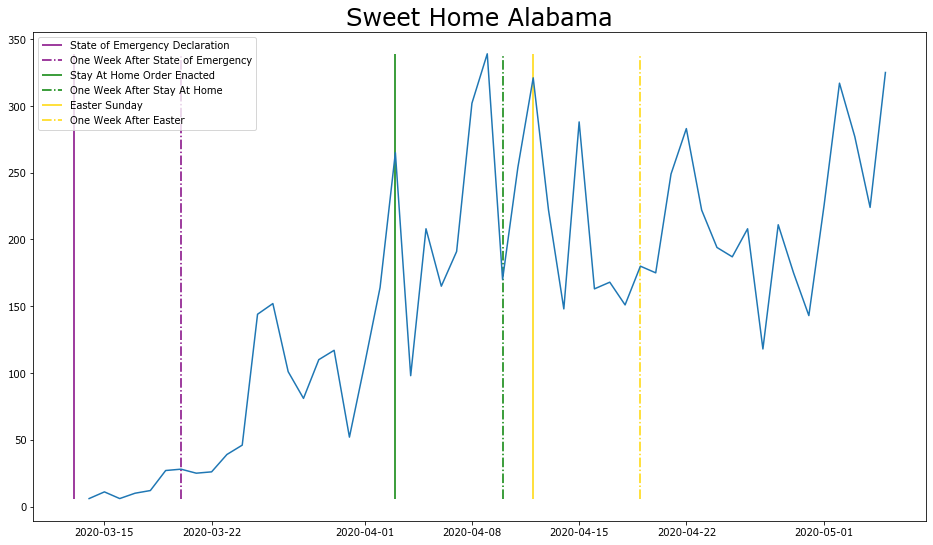

In [139]:
daily_change(alabama_data, 'Sweet Home Alabama', easter='On')

## Alaska (AK)

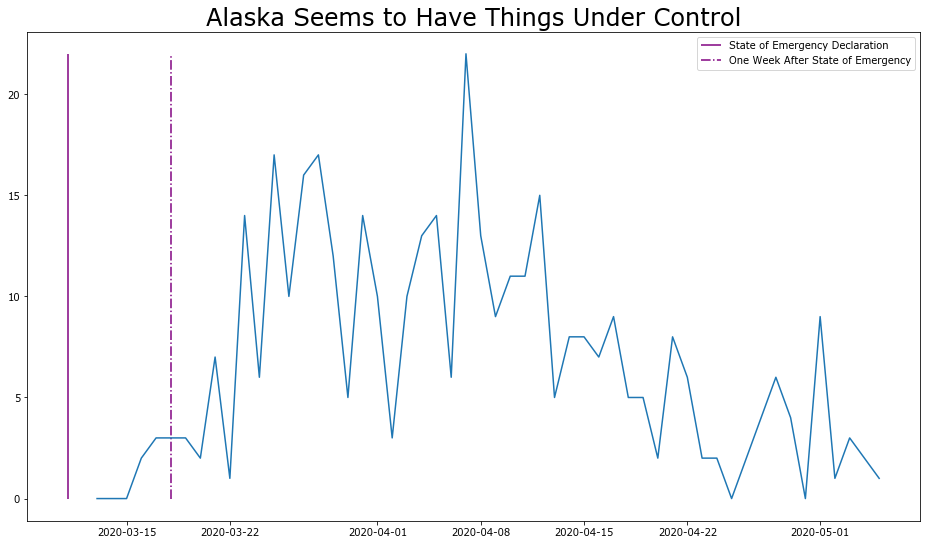

In [140]:
daily_change(alaska_data, "Alaska Seems to Have Things Under Control")

## American Samoa (AS)

In [141]:
# daily_change(american_samoa_data)

## Arizona (AZ)

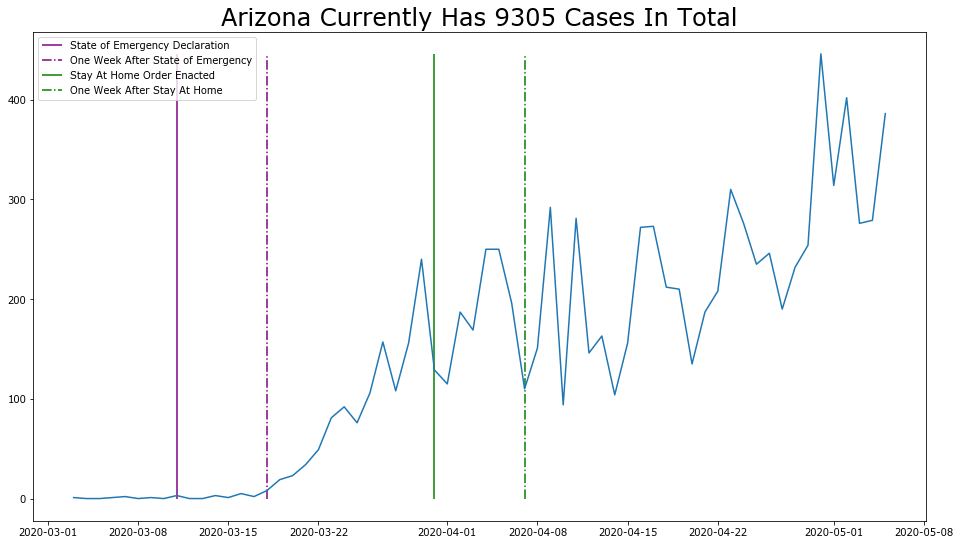

In [142]:
daily_change(arizona_data[37:])

## Arkansas (AR)

In [ ]:
daily_change(arkansas_data)

## California (CA)

In [ ]:
daily_change(california_data[37:])

## Colorado (CO)

In [ ]:
daily_change(colorado_data)

## Connecticut (CT)

In [ ]:
daily_change(connecticut_data)

## Delaware (DE)

In [ ]:
daily_change(delaware_data)

## District of Columbia (DC)

In [ ]:
daily_change(dc_data)

## Florida (FL)

In [ ]:
daily_change(florida_data)

## Georgia (GA)

In [ ]:
daily_change(georgia_data, end_of_stay_at_home=dt.date(2020, 4, 30))

# https://thehill.com/homenews/state-watch/495527-georgia-to-lift-stay-at-home-order-for-most-residents-friday

## Guam (GU)

In [ ]:
daily_change(guam_data)

## Hawaii (HI)

In [ ]:
daily_change(hawaii_data)

## Idaho (ID)

In [ ]:
daily_change(idaho_data)

## Illinois (IL)

In [ ]:
daily_change(illinois_data[37:])

## Indiana (IN)

In [ ]:
daily_change(indiana_data)

## Iowa (IA)

In [ ]:
daily_change(iowa_data, easter="Bad")

## Kansas (KS)

In [ ]:
daily_change(kansas_data)

## Kentucky (KY)

In [ ]:
daily_change(kentucky_data)

## Louisiana (LA)

In [ ]:
daily_change(louisiana_data)

## Maine (ME)

In [ ]:
daily_change(maine_data)

## Maryland (MD)

In [ ]:
daily_change(maryland_data)

## Massachusetts (MA)

In [ ]:
daily_change(massachusetts_data[30:])

# Patriots' Day is a local holiday in the state that would usually have a marathon happening during it
# plt.vlines(x=dt.date(2020, 4, 18), ymin=massachusetts_data.change_in_cases.min(), ymax=massachusetts_data.change_in_cases.max(), label="Begining of Patriots' Day Weekend", color='red')
# plt.vlines(x=dt.date(2020, 4, 25), ymin=massachusetts_data.change_in_cases.min(), ymax=massachusetts_data.change_in_cases.max(), label="One Week After Begining of Patriots' Day Weekend", color='red', linestyle='dashdot')

# plt.legend()

## Michigan (MI)

In [ ]:
daily_change(michigan_data)

## Minnesota (MN)

In [ ]:
daily_change(minnesota_data)

## Mississippi (MS)

In [ ]:
daily_change(mississippi_data)

## Missouri (MO)

In [ ]:
daily_change(missouri_data)

## Montana (MT)

In [ ]:
daily_change(montana_data)

## Nebraska (NE)

In [ ]:
daily_change(nebraska_data[15:])

## Nevada (NV)

In [ ]:
daily_change(nevada_data)

## New Hampshire (NH)

In [ ]:
daily_change(new_hampshire_data)

## New Jersey (NJ)

In [ ]:
daily_change(new_jersey_data)

## New Mexico (NM)

In [ ]:
daily_change(new_mexico_data)

## New York (NY)

In [ ]:
daily_change(new_york_data)

## North Carolina (NC)

In [ ]:
daily_change(north_carolina_data)

## North Dakota (ND)

In [ ]:
daily_change(north_dakota_data)

## Northern Mariana Islands (MP)

In [ ]:
daily_change(north_mariana_islands_data)

## Ohio (OH)

In [ ]:
daily_change(ohio_data, easter='Oh Oh')

## Oklahoma (OK)

In [ ]:
daily_change(oklahoma_data)

## Oregon (OR)

In [ ]:
daily_change(oregon_data)

## Pennsylvania (PA)

In [ ]:
daily_change(pennsylvania_data)

## Puerto Rico (PR)

In [ ]:
daily_change(puerto_rico_data, "Puerto Rico's Drop in Cases is Likely Due to False Positive Cases\nBeing Corrected, But I Will Do Some Research")

## Rhode Island (RI)

In [ ]:
daily_change(rhode_island_data)

## South Carolina (SC)

In [ ]:
daily_change(south_carolina_data)

## South Dakota (SD)

In [ ]:
daily_change(south_dakota_data)

## Tennessee (TN)

In [ ]:
daily_change(tennessee_data)

## Texas (TX)

In [ ]:
daily_change(texas_data)

## Utah (UT)

In [ ]:
daily_change(utah_data)

## Vermont (VT)

In [ ]:
daily_change(vermont_data)

## Virgin Islands (VI)

In [ ]:
daily_change(virgin_islands_data)

## Virginia (VA)

In [ ]:
daily_change(virginia_data)

## Washington (WA)

In [ ]:
daily_change(washington_data[20:])

## West Virginia (WV)

In [ ]:
daily_change(west_virginia_data)

## Wisconsin (WI)

In [ ]:
daily_change(wisconsin_data[30:])

## Wyoming (WY)

In [ ]:
daily_change(wyoming_data)

In [ ]:
massachusetts_data.tail(10)

## States with Most Cases

In [ ]:
total_us_data.groupby(total_us_data.state).last().sort_values(by='cases', ascending=False)